In [1]:
! pip list | egrep mxnet

mxnet-cu101mkl                1.6.0.post0    


In [2]:
! pip list | egrep d2l

d2l                           0.14.0         


In [3]:
! pip install -q -U mxnet-cu101mkl==1.6.0.post0
! pip install -q d2l==0.14.0

In [4]:
!git clone "https://github.com/Ravikiran-Bhonagiri/aws-machine-learning-university-accelerated-cv.git"

fatal: destination path 'aws-machine-learning-university-accelerated-cv' already exists and is not an empty directory.


In [5]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet.image import imread, imresize
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

In [6]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

batch_size = 16

path = '/content/aws-machine-learning-university-accelerated-cv/data/final_project_dataset'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

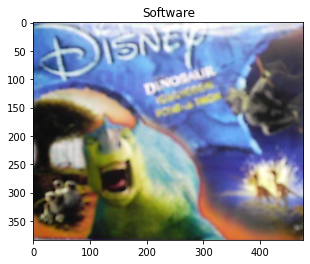

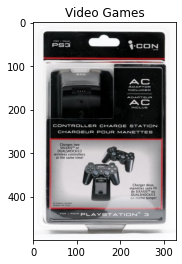

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

im1 = imread(train_path + "/sw/0.jpg")
im2 = imread(train_path + "/vg/0.jpg")

plt.imshow(im1.asnumpy())
plt.title("Software")
plt.show()
plt.imshow(im2.asnumpy())
plt.title("Video Games")
plt.show()

In [8]:
out_classes = 2

net = gluon.nn.Sequential()
net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

# The Flatten layer collapses all axis, except the first one, into one axis.
net.add(gluon.nn.Flatten())
net.add(gluon.nn.Dense(128, activation='relu'))
net.add(gluon.nn.Dense(out_classes))

In [9]:
ctx = d2l.try_gpu() # Set this to CPU or GPU 

epochs = 10
learning_rate = 0.01
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
net.collect_params().initialize(init.Xavier(magnitude=2.24), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

In [11]:
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy_loss(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        val_loss += softmax_cross_entropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

Epoch 0: train loss 0.719, train acc 0.558, val loss 0.654, val acc 0.596
Epoch 1: train loss 0.643, train acc 0.670, val loss 0.644, val acc 0.601
Epoch 2: train loss 0.588, train acc 0.744, val loss 0.601, val acc 0.673
Epoch 3: train loss 0.572, train acc 0.754, val loss 0.644, val acc 0.577
Epoch 4: train loss 0.540, train acc 0.767, val loss 0.608, val acc 0.654
Epoch 5: train loss 0.443, train acc 0.839, val loss 0.594, val acc 0.692
Epoch 6: train loss 0.378, train acc 0.871, val loss 0.568, val acc 0.692
Epoch 7: train loss 0.435, train acc 0.834, val loss 0.587, val acc 0.683
Epoch 8: train loss 0.257, train acc 0.933, val loss 0.628, val acc 0.678
Epoch 9: train loss 0.173, train acc 0.957, val loss 0.654, val acc 0.726


In [12]:
test_path = os.path.join(path, 'test')
test_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

test_acc, test_loss = 0. , 0.

for i, (data, label) in enumerate(test_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        test_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        test_loss += softmax_cross_entropy_loss(output, label).mean()

test_acc /= len(test_loader)
test_loss /= len(test_loader)

print(test_acc)
print(test_loss)
print(len(test_loader))

print("test_loss %.3f, test_acc %.3f" % ( test_loss.asnumpy()[0], test_acc.asnumpy()[0] ) )



[0.71153843]
<NDArray 1 @gpu(0)>

[0.7044869]
<NDArray 1 @gpu(0)>
13
test_loss 0.704, test_acc 0.712
